### Elexon API

### Generation
Shows distribution of use of types of power. Call GET requests to see information on distirbution over period of time.

Example response:
https://data.elexon.co.uk/bmrs/api/v1/generation/outturn/summary?format=json

In [ ]:
{
    "startTime": "2025-11-16T10:55:00Z",
    "settlementPeriod": 22,
    "data": [
      {
        "fuelType": "BIOMASS",
        "generation": 3322
      },
      {
        "fuelType": "CCGT",
        "generation": 12247
      },
      {
        "fuelType": "COAL",
        "generation": 0
      },
      {
        "fuelType": "INTELEC",
        "generation": 999
      },
      {
        "fuelType": "INTFR",
        "generation": 1507
      },
      {
        "fuelType": "INTNED",
        "generation": 212
      },
      {
        "fuelType": "INTNEM",
        "generation": 560
      },
      {
        "fuelType": "INTNSL",
        "generation": 1397
      },
      {
        "fuelType": "INTVKL",
        "generation": 312
      },
      {
        "fuelType": "NPSHYD",
        "generation": 608
      },
      {
        "fuelType": "NUCLEAR",
        "generation": 3364
      },
      {
        "fuelType": "OCGT",
        "generation": 4
      },
      {
        "fuelType": "OIL",
        "generation": 0
      },
      {
        "fuelType": "OTHER",
        "generation": 892
      },
      {
        "fuelType": "WIND",
        "generation": 6217
      }
    ]
  }

: 

In [ ]:
GENERATION_OUTTURN
├── settlement_date (PK)
├── settlement_period (PK, 1-48)
├── fuel_type (PK)
├── generation_mw
├── timestamp_utc
└── created_at (when you fetched it)

PERIOD_SUMMARY
├── settlement_date (PK)
├── settlement_period (PK)
├── total_generation_mw
├── renewable_pct
├── dominant_fuel_type
└── carbon_intensity (calculated)

### Key parameters

settlementDate - Specific date (YYYY-MM-DD format)

settlementPeriod - Specific 30-min period (1-48), optional

from and to - Date range (YYYY-MM-DD)

format - Usually json or csv (defaults to json)

### Use

Use this endpoint to visualise distribution of usage of different energy types at different times.

### Pricing

Example response: https://data.elexon.co.uk/bmrs/api/v1/balancing/settlement/system-prices/2024-02-01?format=json


In [44]:
{
  "dataset": "SYSPRICE",
  "settlementDate": "2024-11-17",
  "settlementPeriod": 25,          # Period 25 = 12:00-12:30
  "systemSellPrice": 85.50,         # £/MWh - what Grid pays generators
  "systemBuyPrice": 82.30,          # £/MWh - what Grid charges generators
  "priceDerivationCode": "NORMAL",  # or "ADMINISTERED" 
  "reserveScarcityPrice": 0.00,     # Extra price when reserves are tight
  "netImbalanceVolume": 152.5,      # MW - was grid short or long?
  "sellPriceAdjustment": 0.00,
  "buyPriceAdjustment": 0.00
}

{'dataset': 'SYSPRICE',
 'settlementDate': '2024-11-17',
 'settlementPeriod': 25,
 'systemSellPrice': 85.5,
 'systemBuyPrice': 82.3,
 'priceDerivationCode': 'NORMAL',
 'reserveScarcityPrice': 0.0,
 'netImbalanceVolume': 152.5,
 'sellPriceAdjustment': 0.0,
 'buyPriceAdjustment': 0.0}

In [45]:
SYSTEM_PRICES
├── settlement_date (PK)
├── settlement_period (PK)
├── system_sell_price
├── system_buy_price
├── net_imbalance_volume
├── price_derivation_code
├── reserve_scarcity_price
└── timestamp_utc

-- Derived/aggregated table
DAILY_PRICE_SUMMARY
├── date (PK)
├── avg_price
├── max_price
├── price_volatility (std dev)
├── num_shortage_periods
├── num_surplus_periods
└── emergency_flag

SyntaxError: invalid character '├' (U+251C) (491292805.py, line 2)

In [ ]:
import requests

BASE_URL = "https://data.elexon.co.uk/bmrs/api/v1"

# Fetch latest generation data
url = f"{BASE_URL}/generation/outturn/summary"
response = requests.get(url, params={'format': 'json'})
data = response.json()
data = data[0]
df = pd.DataFrame(data)
print(df.head())

              startTime  settlementPeriod  \
0  2025-11-16T15:00:00Z                31   
1  2025-11-16T15:00:00Z                31   
2  2025-11-16T15:00:00Z                31   
3  2025-11-16T15:00:00Z                31   
4  2025-11-16T15:00:00Z                31   

                                          data  
0  {'fuelType': 'BIOMASS', 'generation': 3331}  
1    {'fuelType': 'CCGT', 'generation': 16616}  
2        {'fuelType': 'COAL', 'generation': 0}  
3   {'fuelType': 'INTELEC', 'generation': 998}  
4    {'fuelType': 'INTFR', 'generation': 1508}  


In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

BASE_URL = "https://data.elexon.co.uk/bmrs/api/v1/balancing/settlement/system-prices"

def fetch_system_prices(settlement_date: str) -> pd.DataFrame:
    """
    Fetch system prices for a given settlement date from Elexon's BMRS API.
    
    Args:
        settlement_date: Date string in "YYYY-MM-DD" for the settlement date.
        
    Returns:
        pd.DataFrame containing the system price data (if any).
    """
    url = f"{BASE_URL}/{settlement_date}"
    params = {"format": "json"}
    
    resp = requests.get(url, params=params)
    resp.raise_for_status()
    
    data = resp.json()
    
    # The JSON structure may depend on the API version – check what you get.
    # Let's assume the top-level JSON is a list of records (or data is at key "Data")
    if isinstance(data, dict):
        # Sometimes API returns { "Data": [...records...] }
        if "Data" in data:
            records = data["Data"]
        else:
            # fallback: assume the dict itself is one record
            records = [data]
    elif isinstance(data, list):
        records = data
    else:
        records = []
    
    df = pd.DataFrame(records)
    
    # Parse datetime if available
    if "settlementDate" in df.columns:
        df["settlementDate"] = pd.to_datetime(df["settlementDate"])
    if "systemPrice" in df.columns:
        # example: convert price to float
        df["systemPrice"] = pd.to_numeric(df["systemPrice"], errors="coerce")
    
    return df

def main():
    # Example: fetch for yesterday
    today = datetime.utcnow().date()
    yesterday = today - timedelta(days=1)
    ds = yesterday.strftime("%Y-%m-%d")
    
    df = fetch_system_prices(ds)
    data = df['data'][0]
    print(pd.DataFrame(data).head())
    print(pd.DataFrame(data))

    
if __name__ == "__main__":
    main()


  settlementDate  settlementPeriod             startTime  \
0     2025-11-16                 1  2025-11-16T00:00:00Z   
1     2025-11-16                 2  2025-11-16T00:30:00Z   
2     2025-11-16                 3  2025-11-16T01:00:00Z   
3     2025-11-16                 4  2025-11-16T01:30:00Z   
4     2025-11-16                 5  2025-11-16T02:00:00Z   

        createdDateTime  systemSellPrice  systemBuyPrice  bsadDefaulted  \
0  2025-11-17T00:44:32Z       111.000000      111.000000          False   
1  2025-11-17T01:14:34Z        76.860000       76.860000          False   
2  2025-11-17T01:44:30Z       106.000288      106.000288          False   
3  2025-11-17T02:14:49Z       110.000000      110.000000          False   
4  2025-11-17T02:44:28Z       110.000000      110.000000          False   

  priceDerivationCode  reserveScarcityPrice  netImbalanceVolume  ...  \
0                   P                   0.0           30.208690  ...   
1                   P                   0.0 

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

BASE_URL = "https://data.elexon.co.uk/bmrs/api/v1"

# Fetch latest generation data
url = f"{BASE_URL}/generation/outturn/summary"
response = requests.get(url, params={'format': 'json'})
data = response.json()

print(f"API Response type: {type(data)}")
print(f"Keys in response: {data.keys() if isinstance(data, dict) else 'Not a dict'}")

# Handle the response structure properly
if isinstance(data, dict) and 'data' in data:
    latest = data['data'][0]
elif isinstance(data, list):
    latest = data[0]
else:
    print("Unexpected response structure:")
    print(data)
    raise ValueError("Cannot parse API response")

print(f"\nLatest period: {latest.get('startTime', 'N/A')}")
print(f"Settlement period: {latest.get('settlementPeriod', 'N/A')}")

# Create DataFrame from latest generation data
gen_data = pd.DataFrame(latest['data'])
gen_data = gen_data.sort_values('generation', ascending=False)

print(f"\nCurrent generation by fuel type:")
print(gen_data.to_string())

# Fetch historical data
yesterday = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
today = datetime.now().strftime("%Y-%m-%d")

url = f"{BASE_URL}/generation/outturn/summary"
response = requests.get(url, params={'from': yesterday, 'to': today, 'format': 'json'})
hist_data = response.json()

# Process historical data
if isinstance(hist_data, dict) and 'data' in hist_data:
    periods = hist_data['data']
elif isinstance(hist_data, list):
    periods = hist_data
else:
    periods = []

all_data = []
for period in periods:
    for fuel in period['data']:
        all_data.append({
            'time': period['startTime'],
            'period': period['settlementPeriod'],
            'fuel_type': fuel['fuelType'],
            'generation': fuel['generation']
        })

df_gen = pd.DataFrame(all_data)
df_gen['time'] = pd.to_datetime(df_gen['time'])

print(f"\nHistorical data: {len(df_gen)} records from {df_gen['time'].min()} to {df_gen['time'].max()}")

# Fetch system prices
url = f"{BASE_URL}/balancing/settlement/system-prices"
response = requests.get(url, params={'from': yesterday, 'to': today, 'format': 'json'})
price_response = response.json()

if isinstance(price_response, dict) and 'data' in price_response:
    price_data = price_response['data']
elif isinstance(price_response, list):
    price_data = price_response
else:
    price_data = []

df_price = pd.DataFrame(price_data)
if not df_price.empty:
    df_price['settlementDate'] = pd.to_datetime(df_price['settlementDate'])
    print(f"\nPrice data: {len(df_price)} records")
    print(f"\nFirst few price records:")
    df_price.head()
else:
    print("\nNo price data available")

API Response type: <class 'list'>
Keys in response: Not a dict

Latest period: 2025-11-16T16:30:00Z
Settlement period: 34

Current generation by fuel type:
   fuelType  generation
1      CCGT       17692
13     WIND        7665
8   NUCLEAR        3354
0   BIOMASS        3336
11    OTHER        2065
4     INTFR        1508
6    INTNSL        1398
12       PS        1266
3   INTELEC         998
7    NPSHYD         835
5    INTNEM          38
9      OCGT          35
2      COAL           0
10      OIL           0

Historical data: 654 records from 2025-11-16 16:30:00+00:00 to 2025-11-17 15:30:00+00:00

No price data available


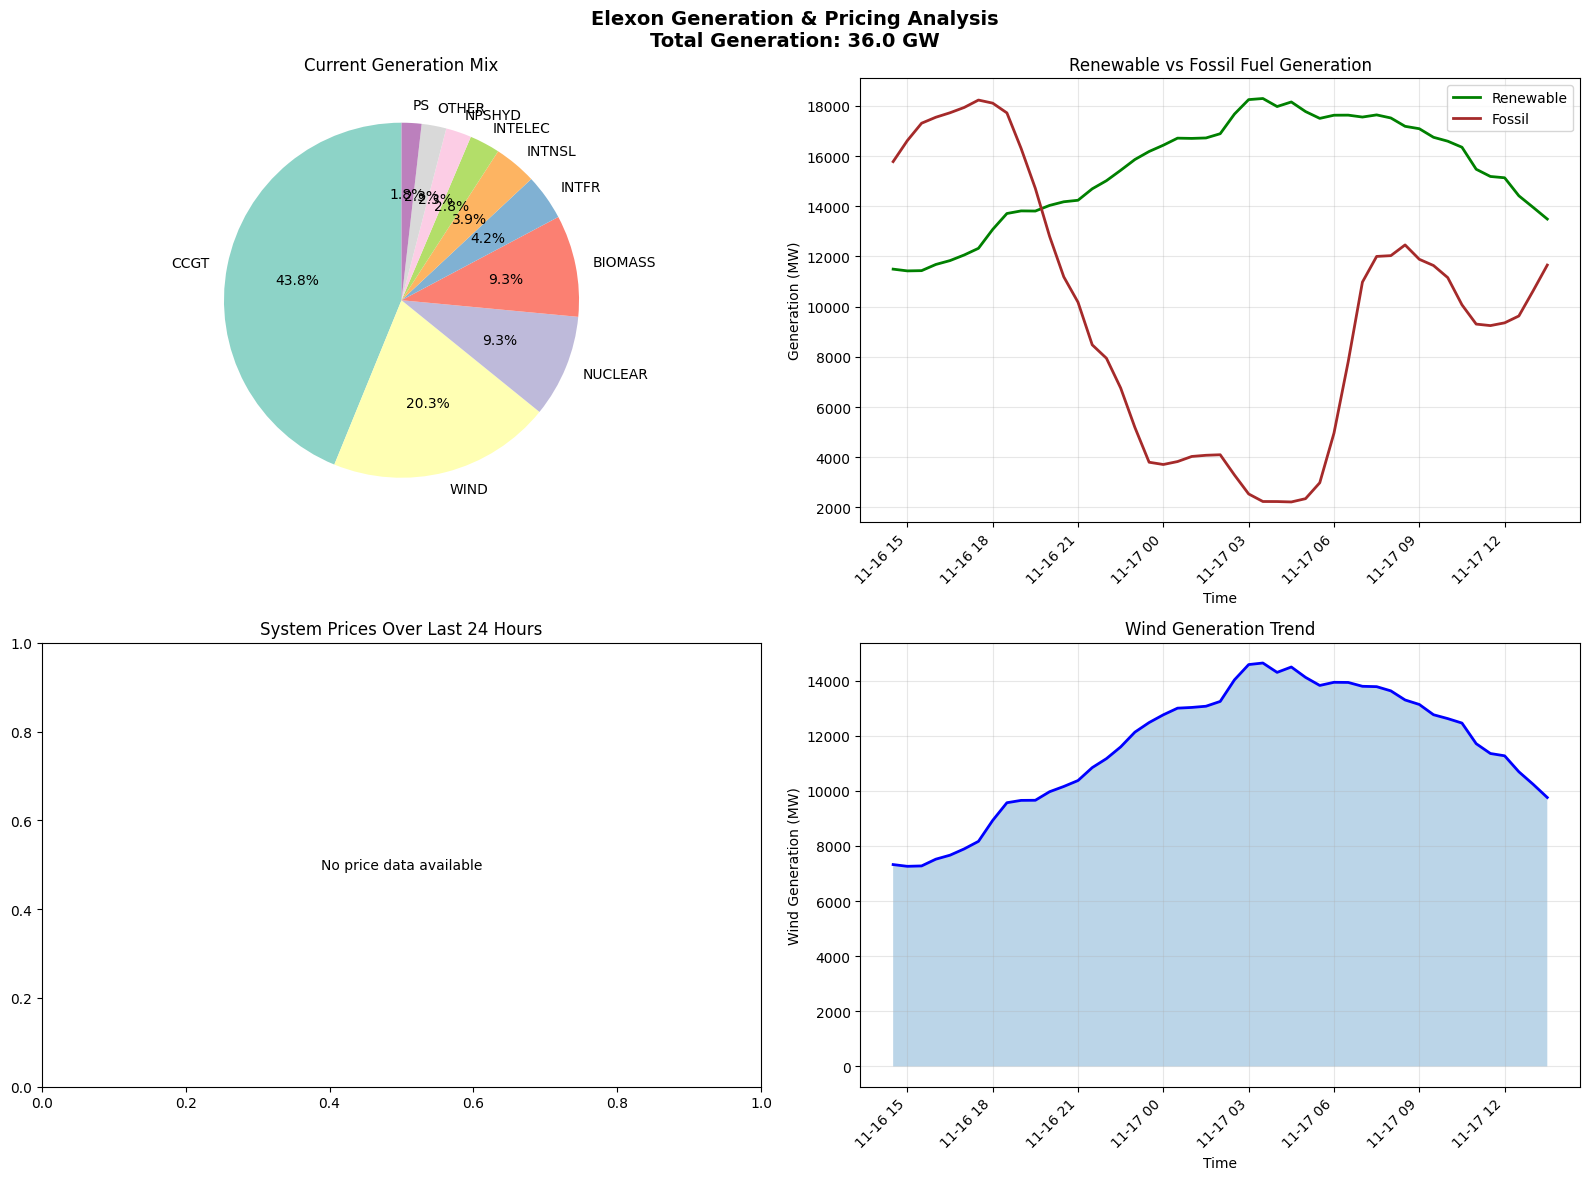

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create 2x2 subplot layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top Left: Current generation pie chart
gen_data_sorted = gen_data[gen_data['generation'] > 100]  # Filter small values
total_gen = gen_data['generation'].sum()

colors = plt.cm.Set3(range(len(gen_data_sorted)))
ax1.pie(gen_data_sorted['generation'], labels=gen_data_sorted['fuelType'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Current Generation Mix')

# Top Right: Renewable vs Fossil over time
renewable_fuels = ['WIND', 'SOLAR', 'NPSHYD', 'BIOMASS']
renewable_over_time = df_gen[df_gen['fuel_type'].isin(renewable_fuels)].groupby('time')['generation'].sum()
fossil_fuels = ['CCGT', 'COAL', 'OCGT', 'OIL']
fossil_over_time = df_gen[df_gen['fuel_type'].isin(fossil_fuels)].groupby('time')['generation'].sum()

ax2.plot(renewable_over_time.index, renewable_over_time.values, 'g-', linewidth=2, label='Renewable')
ax2.plot(fossil_over_time.index, fossil_over_time.values, color='brown', linewidth=2, label='Fossil')
ax2.set_xlabel('Time')
ax2.set_ylabel('Generation (MW)')
ax2.set_title('Renewable vs Fossil Fuel Generation')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Bottom Left: System prices
if not df_price.empty and 'systemSellPrice' in df_price.columns:
    avg_price = df_price['systemSellPrice'].mean()
    ax3.plot(df_price['settlementPeriod'], df_price['systemSellPrice'], 'b-o', 
             linewidth=2, markersize=4, label='System Price')
    ax3.axhline(y=avg_price, color='r', linestyle='--', label=f'Avg: £{avg_price:.2f}')
    ax3.set_xlabel('Settlement Period')
    ax3.set_ylabel('Price (£/MWh)')
    ax3.set_title('System Prices Over Last 24 Hours')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'No price data available', ha='center', va='center')
    ax3.set_title('System Prices Over Last 24 Hours')

# Bottom Right: Wind generation trend
wind_data = df_gen[df_gen['fuel_type'] == 'WIND'].groupby('time')['generation'].sum()

ax4.plot(wind_data.index, wind_data.values, 'b-', linewidth=2, label='Wind')
ax4.fill_between(wind_data.index, wind_data.values, alpha=0.3)
ax4.set_xlabel('Time')
ax4.set_ylabel('Wind Generation (MW)')
ax4.set_title('Wind Generation Trend')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Overall title
fig.suptitle(f'Elexon Generation & Pricing Analysis\nTotal Generation: {total_gen/1000:.1f} GW', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()